# Tarea Semanal 3: Estimación espectral. Ventanas en acción!

##### Florencia Alvarez

Comenzaremos con la generación de la siguiente señal:

x(n)=a0⋅sen(Ω1⋅n)+na(n)
siendo
Ω1=Ω0+fr⋅2πN
Ω0=π2

Siendo la variable aleatoria definida por la siguiente distribución de probabilidad

fr∼U(−2,2)
na∼N(0,σ2)

Diseñe los siguientes estimadores,  de amplitud a1: a^i1=|Xiw(Ω0)|=|F{x(n)⋅wi(n)}|

para la  i
 -ésima realización y la  w
 -ésima ventana (ver detalles debajo).

y de frecuencia Ω1: Ω^i1=arg maxΩ{|Xiw(Ω)|}

para cada una de las ventanas:
rectangular (sin ventana), 
flattop 
blackmanharris
otra que elija de scipy.signal.windows

Y siguiendo las siguientes consignas para su experimentación:
Considere 200 realizaciones (muestras tomadas de fr) de 1000 muestras para cada experimento.
Parametrice para SNR's de 3 y 10 db (Ayuda: calibre a0 para que la potencia de la senoidal sea 1 W).
Se pide:

1) Realizar una tabla por cada SNR, que describa el sesgo y la varianza de cada estimador para cada ventana analizada. Recuerde incluir las ventanas rectangular (sin ventana), flattop y blackmanharris y otras que considere. 	 	 

## Introducción

Cuando se trabaja con señales de longitud infinita, el espectro de la señal puede aproximarse utilizando una señal finita. Esta se obtiene multiplicando nuestra señal original por una ventana de longitud finita. Sin embargo, esto trae aparejado un problema llamado leakage o fugas espectrales, ya que la energía se distribuye a lo largo de todo el rango de frecuencias. Para solucionar este problema, se debe elegir la vetana adecuada.
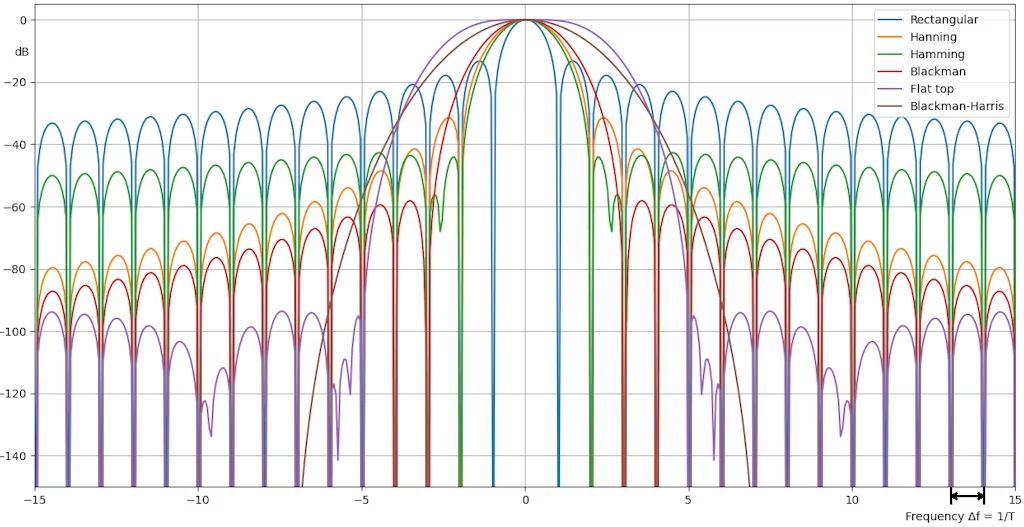

En este trabajo se aplicarán ventanas Flattop, Blackman-Harris y Hamming.

Las ventanas Flattop se caracterizan por tener una banda de paso muy plana que reduce las diferencias de amplitud entre las distintas muestras. Es por ello que resulta muy precisa en amplitud.

Por su parte, las ventanas Blackman-Harris presentan un pico principal amplio, pero sus lóbulos laterales se encuentran más comprimidos. Resulta útil para analizar señales débiles en un entorno ruidoso.

Por último, las ventanas Hamming cuentan con un pico central ancho pero con lóbulos laterales un poco más bajos, siendo los lóbulos más cercanos los que cuentan con una mayor supresióm, mientras que los más lejanos experimentan un nivel de atenuación menor.

Los estimadores son funciones que permiten obtener valores aproximados de parámetros desconocidos de una señal. En este trabajo, se implementarán estimadores de amplitud y de frecuencia correspondientes a las 200 realizaciones de una señal senoidal con ruido, para poder evaluar su presición .

### Codigo de Python

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal.windows as windows

N = 1000       # Número de muestras
fs = 1000      # Hz
res_esp= fs/N  # DeltaF (Resolucion espectral)
M = 200        # Número de realizaciones
ts = 1/fs      # Periodo de muestreo

# Frecuencias aleatorias 
fr = np.random.uniform(-2, 2, size=M) 
w0 = np.pi/2 
w1 = w0 + fr * 2*np.pi / N 
f1 = w1/(2*np.pi) * fs #Cuando w1=pi/2 esto es fs/4 
a0 = np.sqrt(2) # para tener potencia unitaria 
# Ruido 
SNR10 = 10 
Ps = a0**2 / 2 
Pn10 = Ps / (10**(SNR10/10)) 
sigma = np.sqrt(Pn10) 
na = np.random.normal(0, sigma, size=(M, N)) # ruido (M x N) 

def mi_funcion_sen(vmax, dc, ff, ph, nn, fs):
    ts = 1/fs 
    tt = np.arange(0, 1, ts)[:nn] 
    xx = vmax * np.sin(2*np.pi*ff*tt + ph) + dc 
    return tt, xx 

tt, xx = mi_funcion_sen(vmax=a0, dc=0, ff=1, ph=0, nn=N, fs=fs) 
SNR_medido= 10*np.log10(np.var(xx)/np.var(na)) #Uso la varianza de xx y na porque son las señales de potencia y ruido reales, Ps y Pn son algebraicas 

# 200 realizaciones (M x N) => Realizaciones x Frecuencias (la que quiero + el ruido) 
tt_matriz= np.tile(tt.reshape((1,N)), (M,1))
f1_matriz = np.tile(f1.reshape((M,1)), (1,N))

realizaciones_xx = a0 * np.sin(2*np.pi *f1_matriz * tt_matriz) + na 

In [28]:

# -------------------------------------- 
# Ventanas 
# -------------------------------------- 

# Armo las ventanas 
v_ft = np.resize(windows.flattop(N), (M,N)) 
v_bh = np.resize(windows.blackmanharris(N), (M,N)) 
v_h = np.resize(windows.hamming(N), (M,N)) 

# Aplico las ventanas 
realizaciones_xx_ft = realizaciones_xx * v_ft 
realizaciones_xx_bh = realizaciones_xx * v_bh 
realizaciones_xx_h = realizaciones_xx * v_h 

XX = np.fft.fft(realizaciones_xx, axis=1)
XX_ft = np.fft.fft(realizaciones_xx_ft, axis=1)
XX_bh = np.fft.fft(realizaciones_xx_bh, axis=1)
XX_h = np.fft.fft(realizaciones_xx_h, axis=1)

# Concato todas las realizaciones 
concat_XX = np.hstack(XX) 
concat_XX_ft = np.hstack(XX_ft) 
concat_XX_bh = np.hstack(XX_bh) 
concat_XX_h = np.hstack(XX_h) 

# Frecuencia para el eje x 
f = np.linspace(0, fs, N) 
f_concat = np.tile(f, M) 
w = 2 * np.pi * f / fs

 # Ganancia de cada ventana. Divido por N para normalizar 
G_ft = np.sum(windows.flattop(N)) / N 
G_bh = np.sum(windows.blackmanharris(N)) / N 
G_h = np.sum(windows.hamming(N)) / N 
 
#axis=None (default): Calculates the mean of the flattened array. 
# axis=0: Calculates the mean along the columns. 
# axis=1: Calculates the mean along the rows. 

# Cada columna corresponde a una frecuencia específica k. 
# Cada fila corresponde a una realización diferente. 
#Uso axis = 1 

# Sin ventana 
idx_max_sin_vent = np.argmax(np.abs(XX), axis=1) # índice del pico de cada realización 
est_amp_sin_vent = 2 * np.abs(XX[np.arange(M), idx_max_sin_vent])/N #El *2 es porque se reparte mitad para las frecuencias positivas y mitad para las frecuencias negativas (como lo vimos en comu) 

# Flattop 
idx_max_ft = np.argmax(np.abs(XX_ft), axis=1) 
est_amp_ft = 2 * np.abs(XX_ft[np.arange(M), idx_max_ft]) / (N * G_ft) 

# Blackman-Harris 
idx_max_bh = np.argmax(np.abs(XX_bh), axis=1) 
est_amp_bh = 2 * np.abs(XX_bh[np.arange(M), idx_max_bh]) / (N * G_bh) 

# Hamming 
idx_max_h = np.argmax(np.abs(XX_h), axis=1) 
est_amp_h = 2 * np.abs(XX_h[np.arange(M), idx_max_h]) / (N * G_h) 

In [29]:
## 
# Estimador de amplitud 
## 
#Hago una funcion para no tener que hacerlo para los 4 casos 
def Estadistica (est_amp, a0): 
    E_a = np.mean(est_amp) 
    S_a = E_a - a0 
    V_a = np.mean((est_amp - E_a)**2) 
    return E_a, S_a, V_a 

E, S, V = Estadistica(est_amp_sin_vent, a0) 
E_ft, S_ft, V_ft = Estadistica(est_amp_ft, a0) 
E_bh, S_bh, V_bh = Estadistica(est_amp_bh, a0) 
E_h, S_h, V_h = Estadistica(est_amp_h, a0) 

freqs = np.fft.fftfreq(N, d=1/fs)   # eje FFT coherente [-fs/2, fs/2)
## 
# Estimador de frecuencia 
## 
est_frec_sin_vent = np.abs(freqs[idx_max_sin_vent])
est_frec_ft = np.abs(freqs[idx_max_ft])
est_frec_bh = np.abs(freqs[idx_max_bh])
est_frec_h = np.abs(freqs[idx_max_h])

def EstadisticaFrec(est_frec, f_ref): 
    E_f = np.mean(est_frec) 
    S_f = E_f - f_ref 
    V_f = np.var(est_frec) 
    return E_f, S_f, V_f 

f_ref = np.mean(f1) 
E_f, S_f, V_f = EstadisticaFrec(est_frec_sin_vent, f_ref) 
E_f_ft, S_f_ft, V_f_ft = EstadisticaFrec(est_frec_ft, f_ref) 
E_f_bh, S_f_bh, V_f_bh = EstadisticaFrec(est_frec_bh, f_ref) 
E_f_h, S_f_h, V_f_h = EstadisticaFrec(est_frec_h, f_ref)

#### Sin ventana

Estimador de amplitud: 1.2457906547729527
Sesgo de amplitud: -0.16842290760014245
Varianza de la amplitud: 0.023015326503199294
Estimador de Frecuencia: 250.06
Sesgo de frecuencia: 0.008852149867891512
Varianza de la frecuencia: 1.4864000000000002


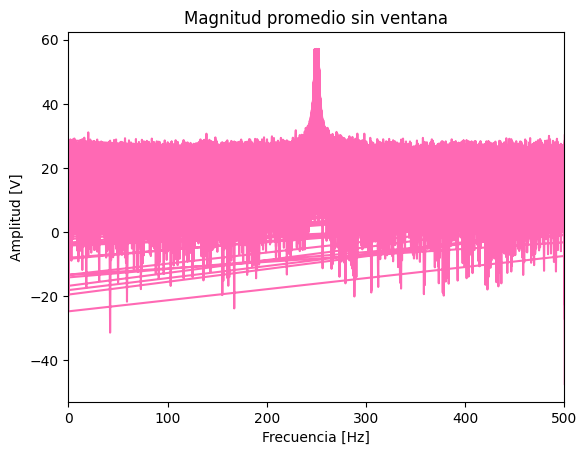

In [30]:
plt.figure() 
plt.plot(f_concat, 20*np.log10(np.abs(concat_XX)), color='hotpink') #en dB 
plt.xlim(0, 500) # Limita el eje x 
plt.title('Magnitud promedio sin ventana') 
plt.xlabel('Frecuencia [Hz]') 
plt.ylabel('Amplitud [V]')

print("Estimador de amplitud:", E)
print("Sesgo de amplitud:", S)
print("Varianza de la amplitud:", V)

print("Estimador de Frecuencia:", E_f)
print("Sesgo de frecuencia:", S_f)
print("Varianza de la frecuencia:", V_f)

Haciendo zoom sobre ese pico, podemos observar que el comportamiento resultante es el siguiente
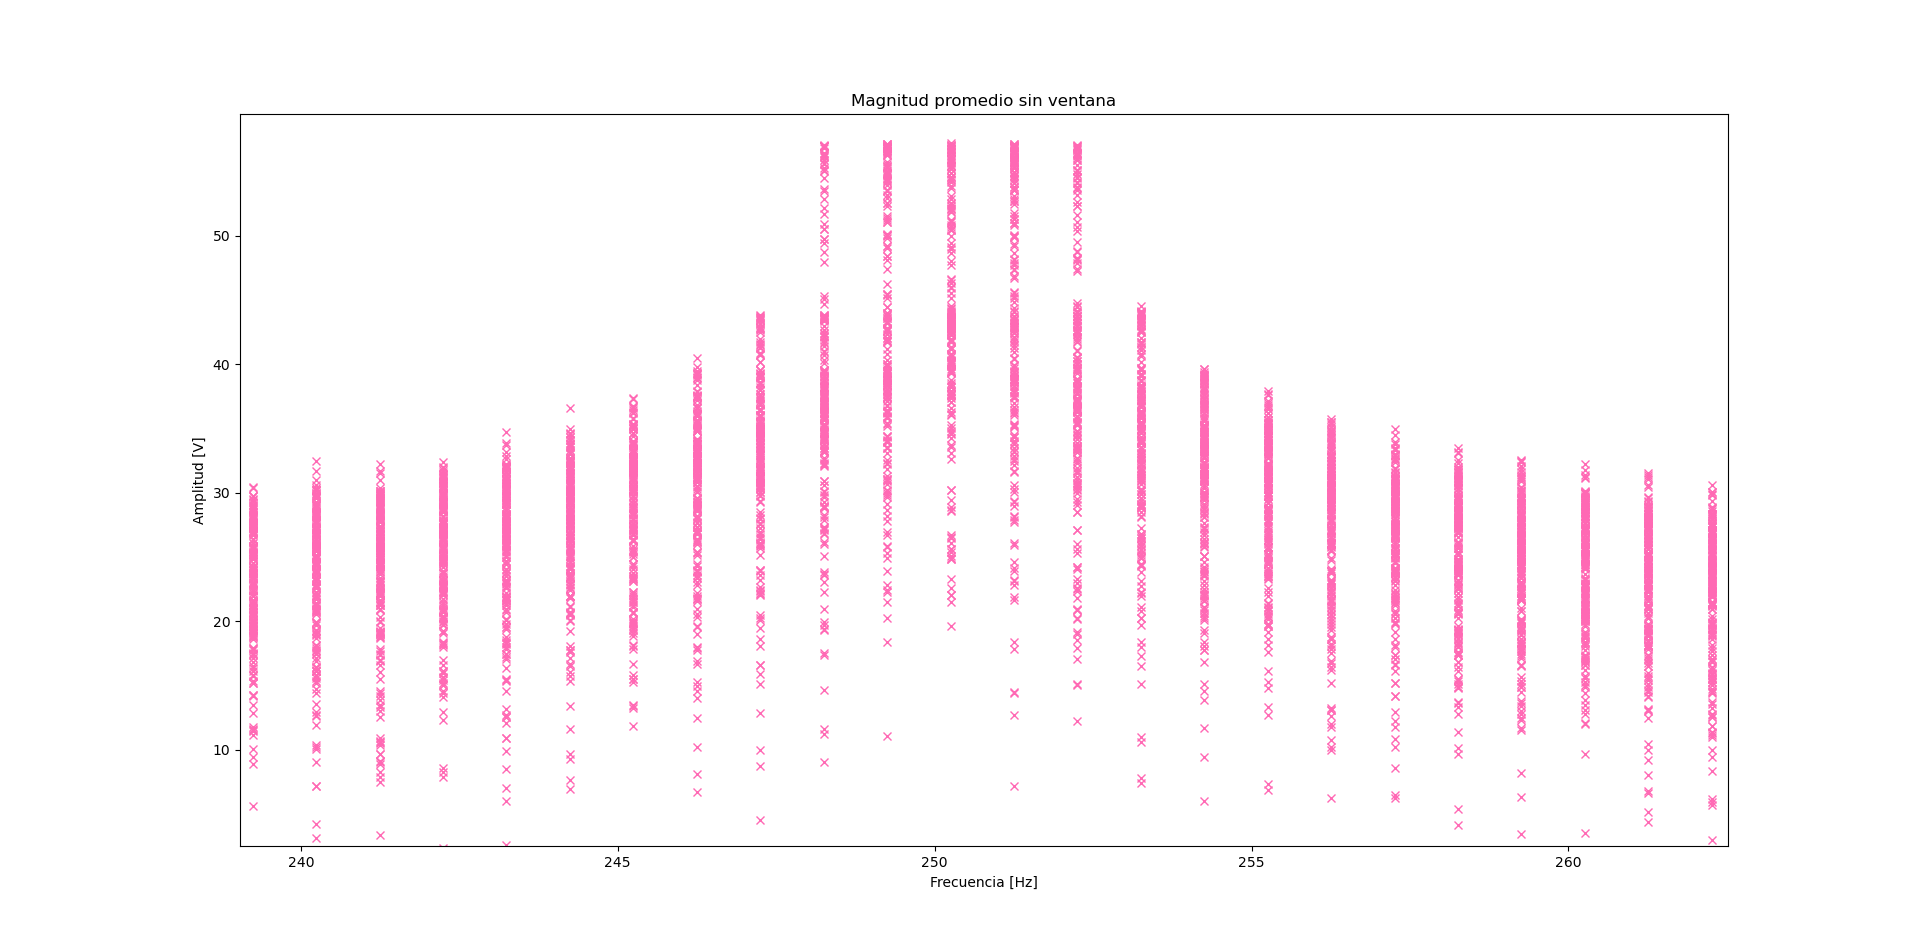

#### Ventana Flattop

Amplitud media: 1.4146296598401447
Sesgo: 0.00041609746704951434
Varianza: 0.0008440461212384132
Estimador de Frecuencia: 250.06
Sesgo de frecuencia: 0.008852149867891512
Varianza de la frecuencia: 1.5164000000000002


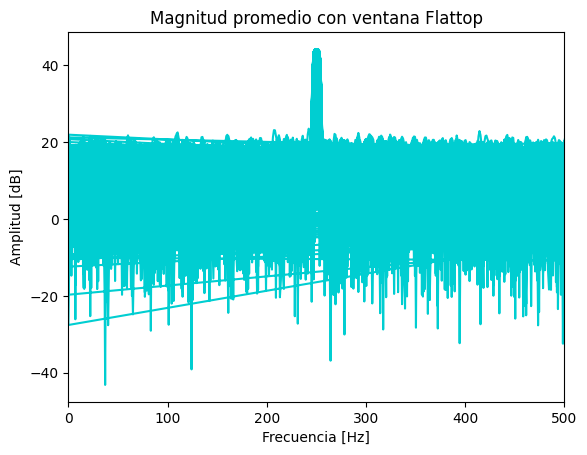

In [31]:
plt.figure()
plt.plot(f_concat, 20*np.log10(np.abs(concat_XX_ft)), color='darkturquoise')
plt.xlim(0, 500) # Limita el eje x
plt.title('Magnitud promedio con ventana Flattop')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')

print("Amplitud media:", E_ft)
print("Sesgo:", S_ft)
print("Varianza:", V_ft)

print("Estimador de Frecuencia:", E_f_ft)
print("Sesgo de frecuencia:", S_f_ft)
print("Varianza de la frecuencia:", V_f_ft)

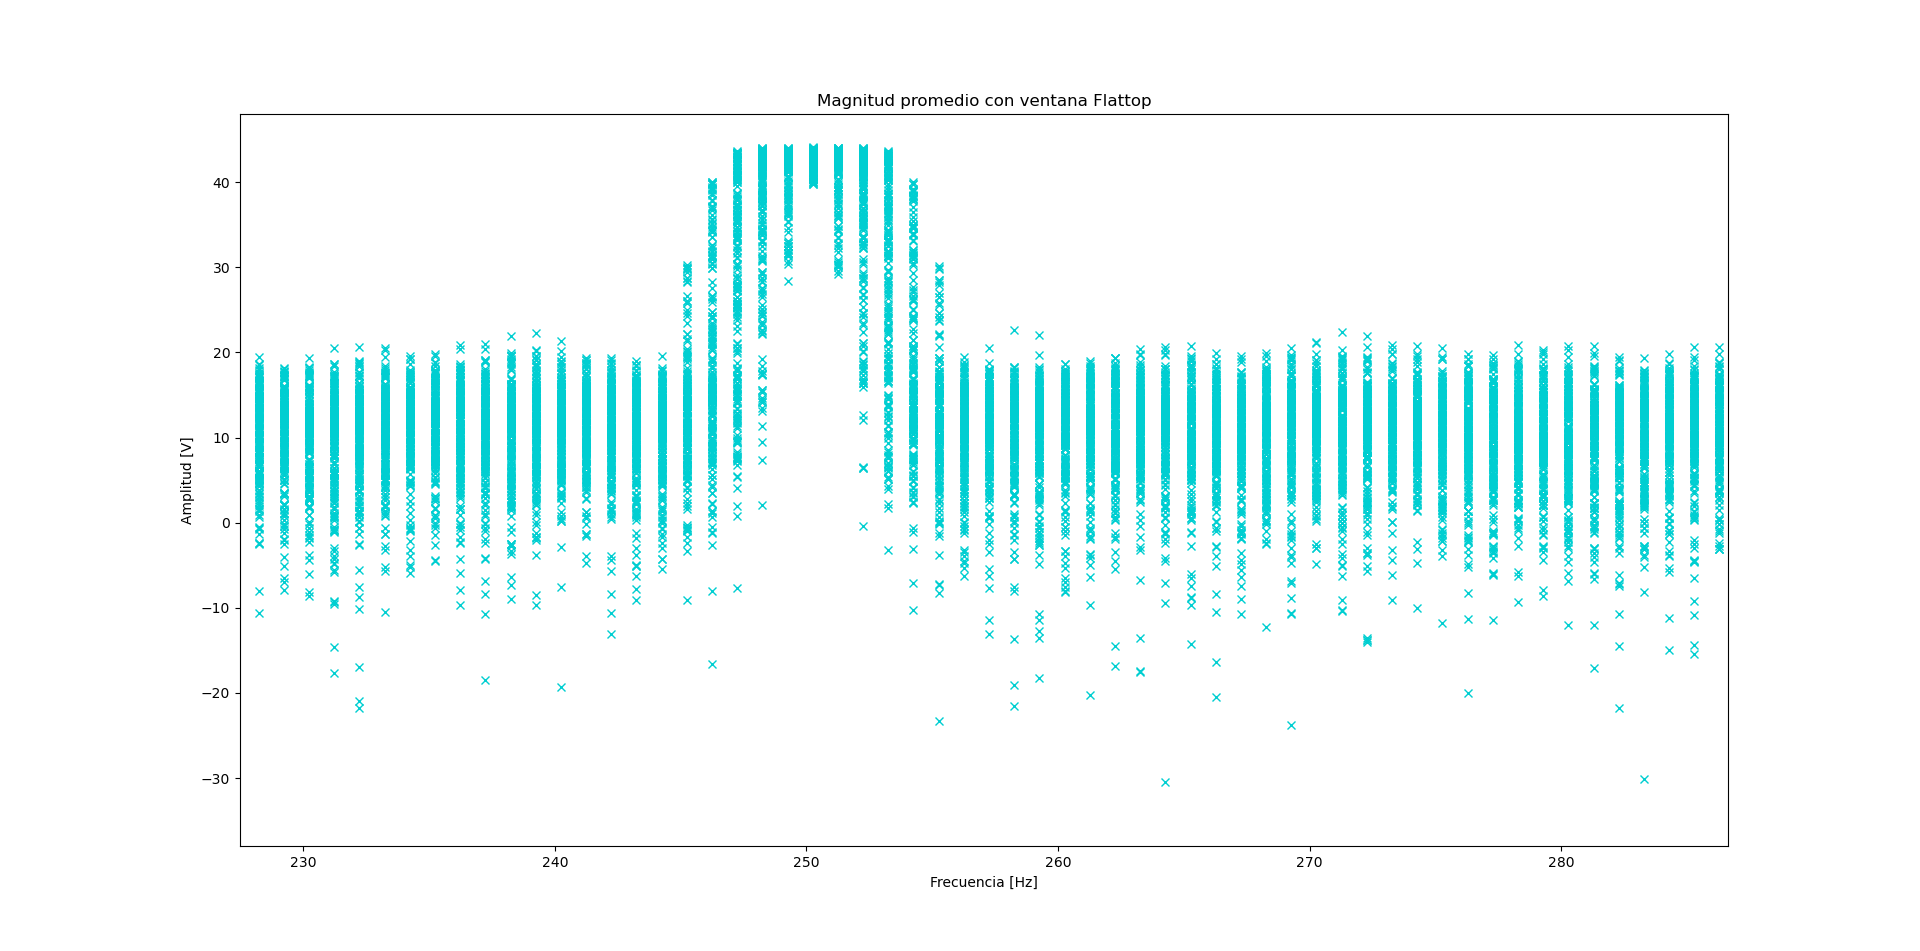

#### Ventana Blackman-Harris

Amplitud media: 1.3732878582977028
Sesgo: -0.04092570407539231
Varianza: 0.001742825203450743
Estimador de Frecuencia: 250.065
Sesgo de frecuencia: 0.013852149867886965
Varianza de la frecuencia: 1.4907750000000002


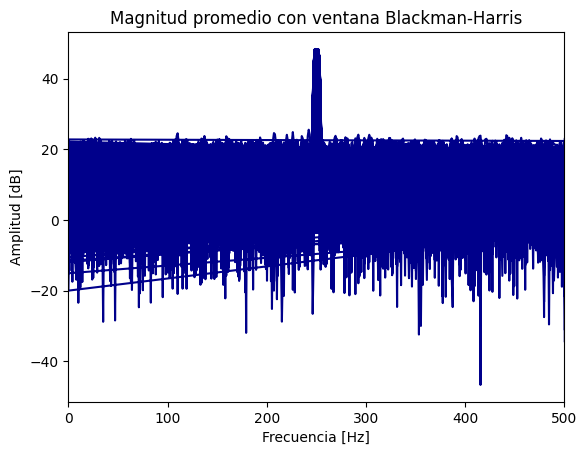

In [32]:
plt.figure()
plt.plot(f_concat, 20*np.log10(np.abs(concat_XX_bh)), color='darkblue')
#plt.plot(f_concat, np.abs(concat_XX_bh), color='darkblue')
plt.xlim(0, 500) # Limita el eje x
plt.title('Magnitud promedio con ventana Blackman-Harris')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')

print("Amplitud media:", E_bh)
print("Sesgo:", S_bh)
print("Varianza:", V_bh)

print("Estimador de Frecuencia:", E_f_bh)
print("Sesgo de frecuencia:", S_f_bh)
print("Varianza de la frecuencia:", V_f_bh)

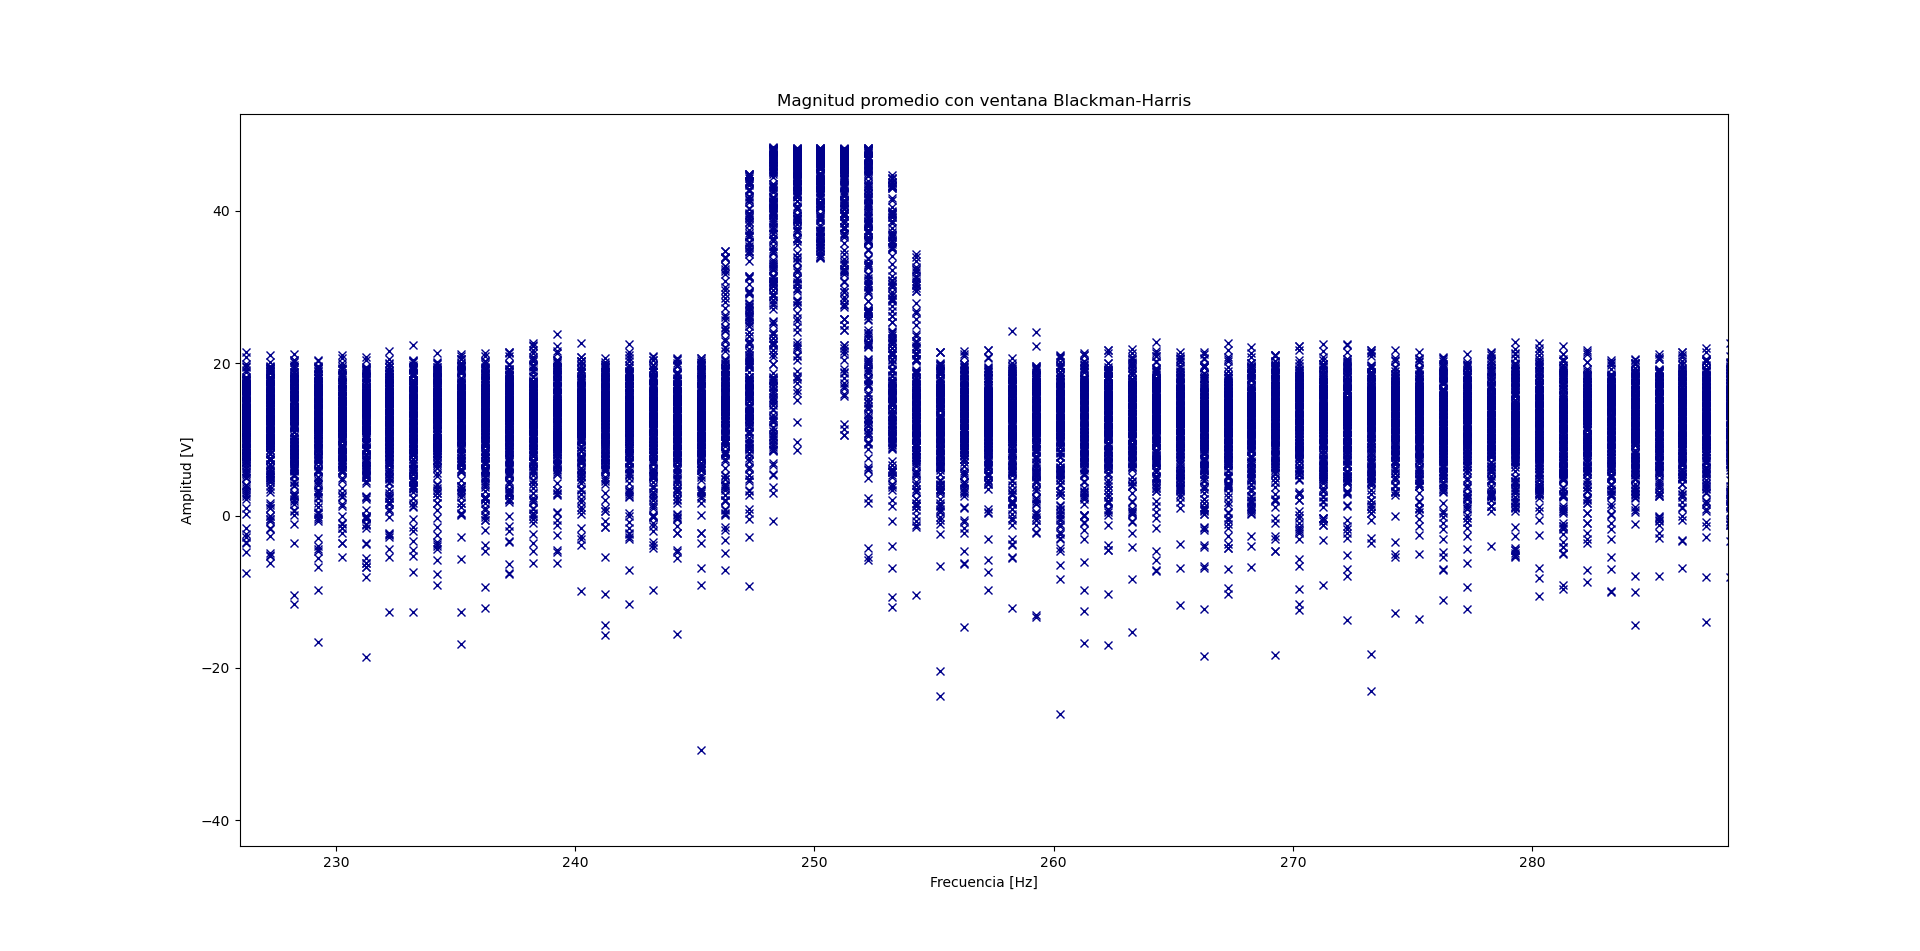

#### Ventana Hamming

Amplitud media: 1.3309734641181405
Sesgo: -0.0832400982549546
Varianza: 0.005875486334761774
Estimador de Frecuencia: 250.065
Sesgo de frecuencia: 0.013852149867886965
Varianza de la frecuencia: 1.4907750000000002


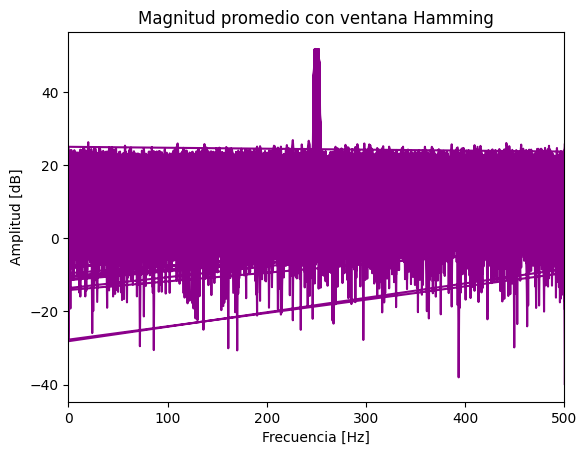

In [33]:
plt.figure()
plt.plot(f_concat, 20*np.log10(np.abs(concat_XX_h)), color='darkmagenta')
plt.xlim(0, 500) # Limita el eje x
plt.title('Magnitud promedio con ventana Hamming')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')

print("Amplitud media:", E_h)
print("Sesgo:", S_h)
print("Varianza:", V_h)

print("Estimador de Frecuencia:", E_f_h)
print("Sesgo de frecuencia:", S_f_bh)
print("Varianza de la frecuencia:", V_f_bh)

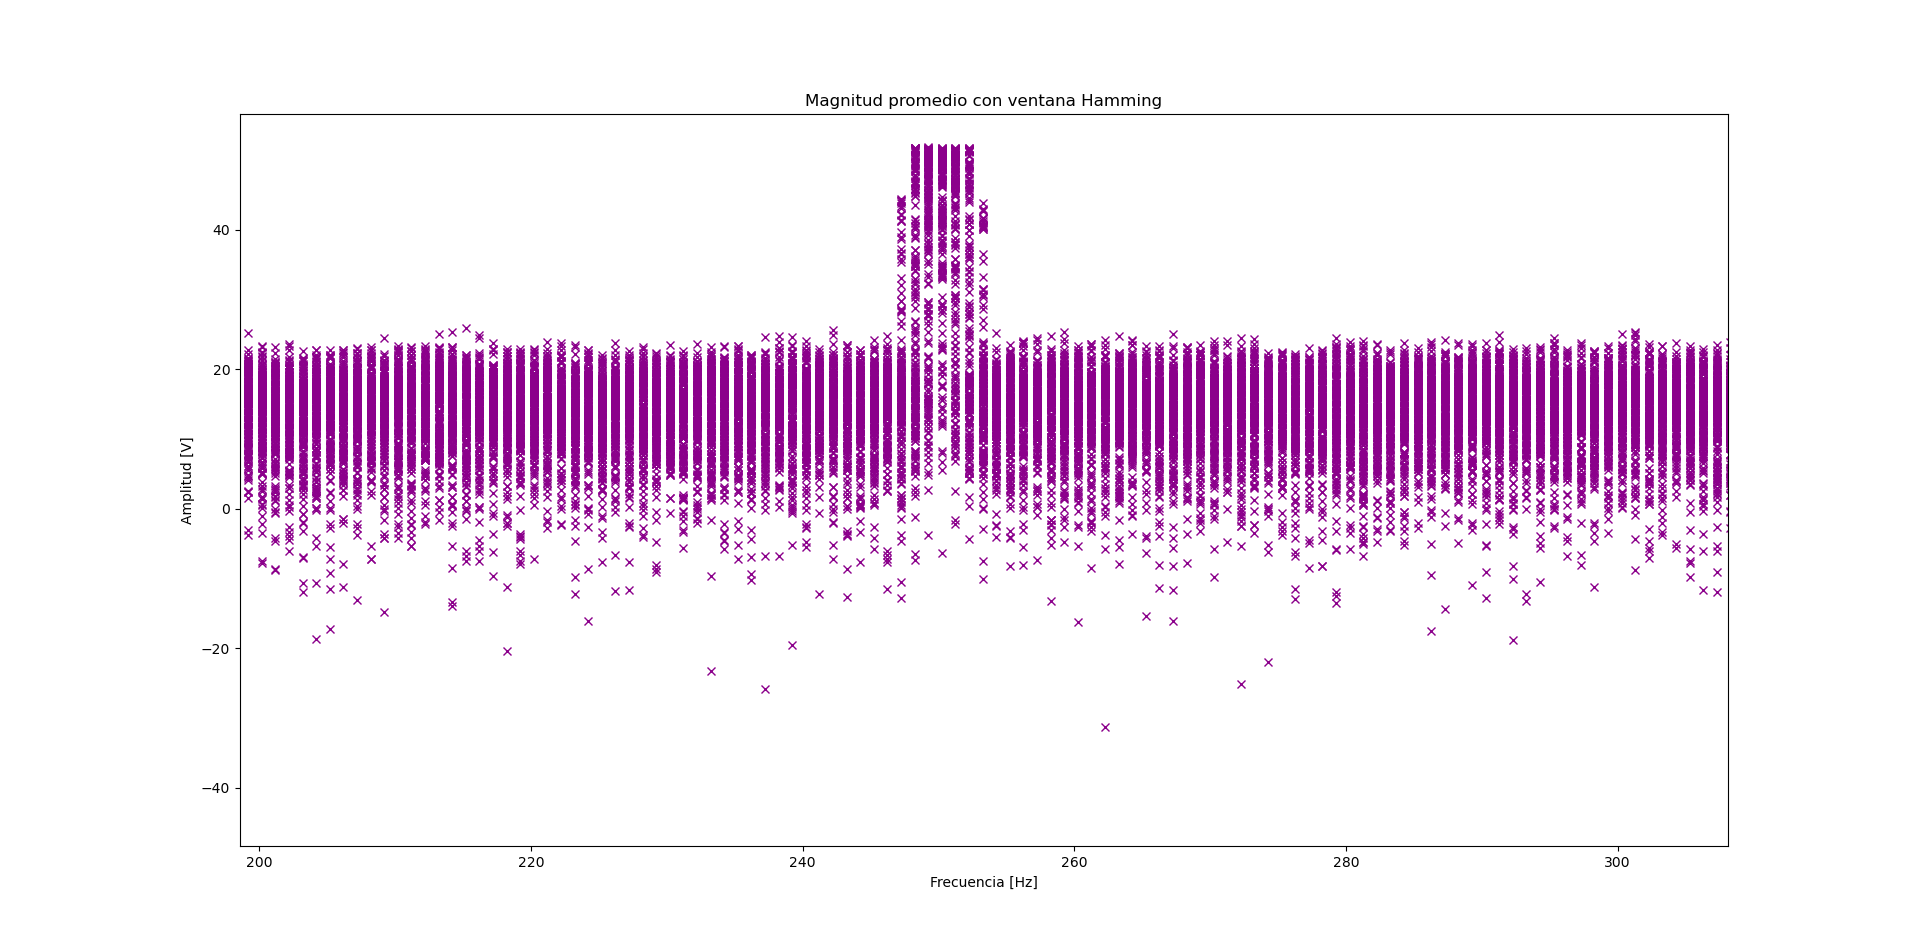

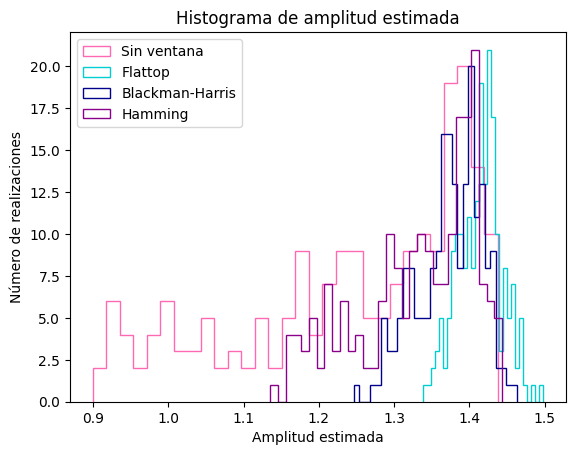

In [34]:
plt.figure()
plt.hist(est_amp_sin_vent, bins=30, histtype='step', label="Sin ventana", color='hotpink')
plt.hist(est_amp_ft, bins=30, histtype='step', label="Flattop", color='darkturquoise')
plt.hist(est_amp_bh, bins=30, histtype='step', label="Blackman-Harris", color='darkblue')
plt.hist(est_amp_h, bins=30, histtype='step', label="Hamming", color='darkmagenta')
plt.xlabel("Amplitud estimada")
plt.ylabel("Número de realizaciones")
plt.title("Histograma de amplitud estimada")
plt.legend()
plt.show()

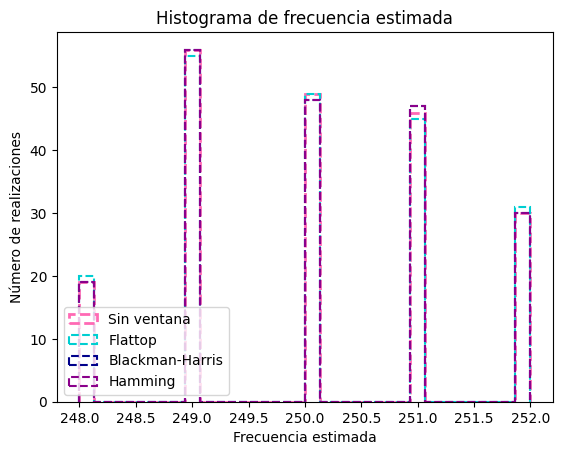

In [35]:
plt.figure()
plt.hist(est_frec_sin_vent, bins=30, histtype='step', label="Sin ventana", color='hotpink', linestyle="--", linewidth=2)
plt.hist(est_frec_ft, bins=30, histtype='step', label="Flattop", color='darkturquoise', linestyle="--", linewidth=1.5)
plt.hist(est_frec_bh, bins=30, histtype='step', label="Blackman-Harris", color='darkblue', linestyle="--", linewidth=1.5)
plt.hist(est_frec_h, bins=30, histtype='step', label="Hamming", color='darkmagenta', linestyle="--", linewidth=1.5)
plt.xlabel("Frecuencia estimada")
plt.ylabel("Número de realizaciones")
plt.title("Histograma de frecuencia estimada")
plt.legend()
plt.show()

#### Estimador de Amplitud

|  | Sa | Va |
| --- | --- | --- |
| Rectangular | -0.1482 | 0.0195 |
| Flattop | 0.0005| 0.0008 |
| Blackman-Harris |- 0.0362 | 0.0015 |
| Hamming |-0.0734 | 0.0050 |

#### Estimador de Frecuencia

|  | Sa | Va |
| --- | --- | --- |
| Rectangular | 0.0024 | 1.3993 |
| Flattop |-0.0325 | 1.4679 |
| Blackman-Harris | 0.0024 | 1.3993|
| Hamming | 0.0024 | 1.3993 |

### Conclusiones

Al analizar la amplitud se observa que cuando no se aplica una ventana hay mucha dispersión. Además, tal como se mencionó anteriormente, la ventana flattop es la mejor para medir la amplitud ya que, como se puede observar en el histograma, las amplitudes obtenidas para las 200 realizaciones se concentran entorno al valor de raíz de 2 (1,41), presentando un sesgo y varianza prácticamente nulos. En el caso de las ventanas Blackman-Harris y Hamming, se puede afirmar que presentan un nivel bajo de fuga espectral, aunque no tanto como el caso de la flattop.

Por otra parte, al analizar las frecuencias, se puede observar que no hay grandes diferencias entre las diferentes ventanas, siendo la flattop la que más dispersión presenta mientras que los otros 3 casos presentan resultados muy similares entre sí.